In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb


In [28]:
df=pd.read_csv('Titanic_test.csv')

In [30]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [32]:
df.shape

(418, 11)

In [34]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


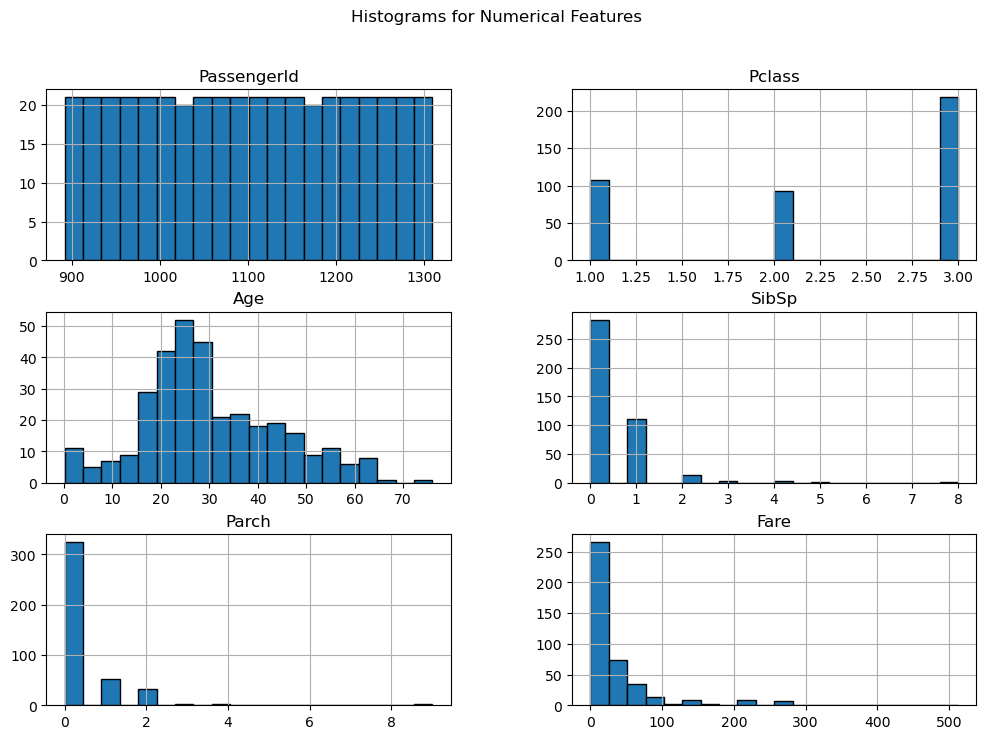

In [36]:
# Histograms for numerical features
df.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histograms for Numerical Features")
plt.show()

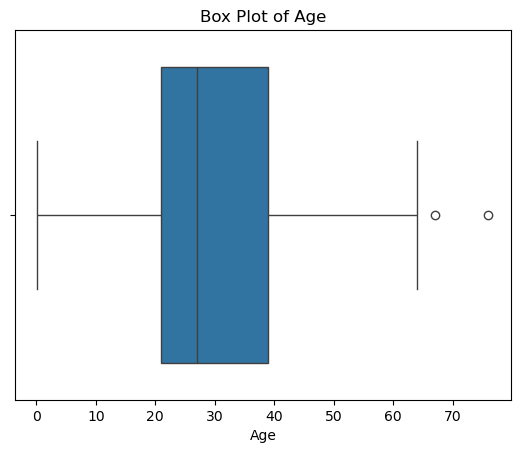

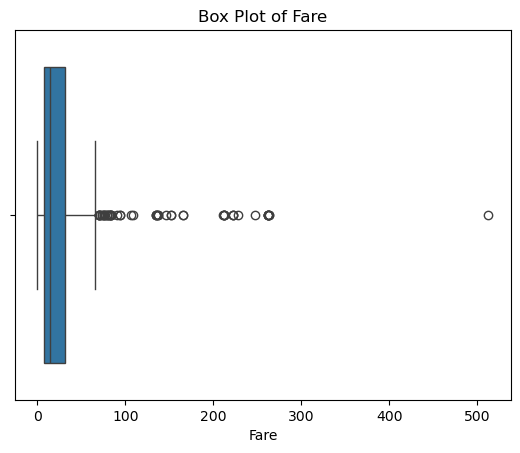

In [38]:
# Box plots for numerical features
numerical_features = ["Age", "Fare"]
for feature in numerical_features:
    sns.boxplot(data=df, x=feature)
    plt.title(f"Box Plot of {feature}")
    plt.show()


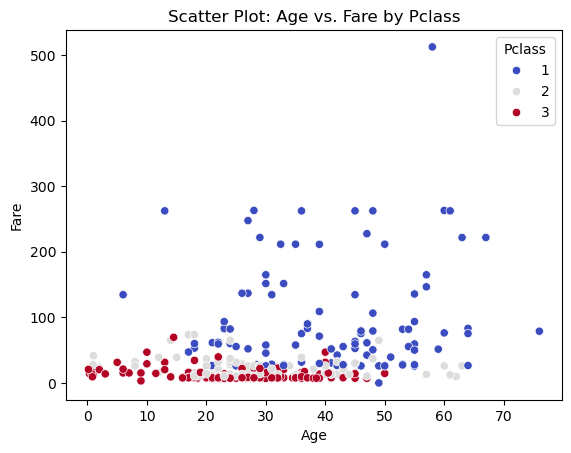

In [40]:
#Visualize Relationships 
# Scatter plot: Age vs. Fare 
sns.scatterplot(data=df, x="Age", y="Fare", hue="Pclass", palette="coolwarm")
plt.title("Scatter Plot: Age vs. Fare by Pclass")
plt.show()


In [42]:
# Simulate a Survived column

np.random.seed(42)
df["Survived"] = np.random.choice([0, 1], size=len(df), p=[0.6, 0.4])  # 60% not survived, 40% survived


In [44]:
# Fill missing Age with median
df["Age"] = df["Age"].fillna(df["Age"].median())

# Fill missing Embarked with mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Drop Cabin due to too many missing values
df = df.drop(columns=["Cabin"])


In [46]:
# Encode categorical variables
label_enc = LabelEncoder()
df["Sex"] = label_enc.fit_transform(df["Sex"])
df["Embarked"] = label_enc.fit_transform(df["Embarked"])


In [48]:
#Split Data into Training and Testing Sets 

# Define features and target
X = df.drop(columns=["Survived", "Name", "Ticket", "PassengerId"])
y = df["Survived"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


LightGBM Model

In [51]:
# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the LightGBM model
print("LightGBM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Precision:", precision_score(y_test, y_pred_lgb))
print("Recall:", recall_score(y_test, y_pred_lgb))
print("F1-Score:", f1_score(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 138, number of negative: 196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 334, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413174 -> initscore=-0.350861
[LightGBM] [Info] Start training from score -0.350861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


XGBoost Model

In [54]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
print("XGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))


C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:05:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
Accuracy: 0.5119047619047619
Precision: 0.3870967741935484
Recall: 0.35294117647058826
F1-Score: 0.36923076923076925


In [60]:
#LightGBM Hyperparameter Tuning 
# Define parameter grid
lgb_params = {"num_leaves": [31, 50], "max_depth": [10, 20], "learning_rate": [0.1, 0.01]}

# Perform grid search
lgb_grid = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42), param_grid=lgb_params, cv=5, scoring="accuracy")
lgb_grid.fit(X_train, y_train)

# Best parameters
print("Best LightGBM Parameters:", lgb_grid.best_params_)


[LightGBM] [Info] Number of positive: 110, number of negative: 157
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 267, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411985 -> initscore=-0.355765
[LightGBM] [Info] Start training from score -0.355765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [64]:
#XGBoost Hyperparameter Tuning 

# Define parameter grid
xgb_params = {"max_depth": [3, 5], "learning_rate": [0.1, 0.01], "n_estimators": [100, 200]}

# Perform grid search
xgb_grid = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                        param_grid=xgb_params, cv=5, scoring="accuracy")
xgb_grid.fit(X_train, y_train)

# Best parameters
print("Best XGBoost Parameters:", xgb_grid.best_params_)

import warnings
warnings.filterwarnings("ignore")

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


      Metric  LightGBM   XGBoost
0   Accuracy  0.476190  0.511905
1  Precision  0.321429  0.387097
2     Recall  0.264706  0.352941
3   F1-Score  0.290323  0.369231


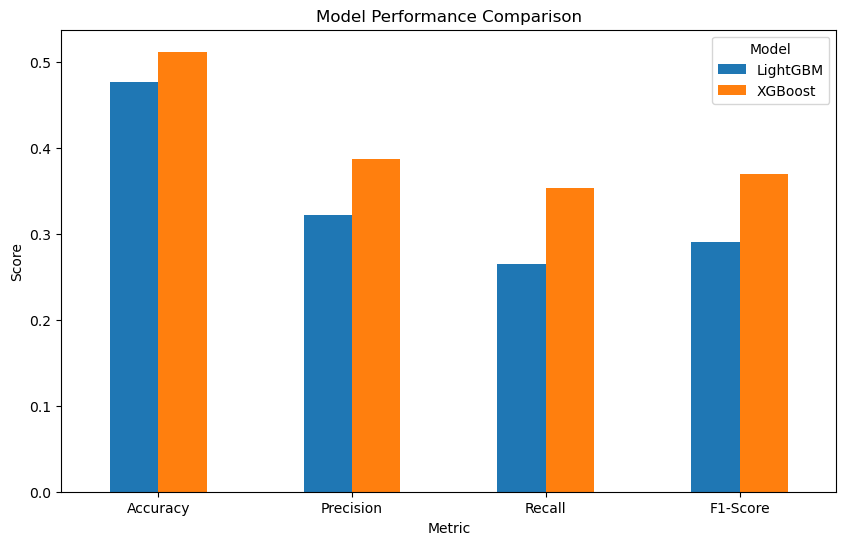

In [66]:
#Comparative Analysis  

# Collect metrics
metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "LightGBM": [accuracy_score(y_test, y_pred_lgb), precision_score(y_test, y_pred_lgb), 
                 recall_score(y_test, y_pred_lgb), f1_score(y_test, y_pred_lgb)],
    "XGBoost": [accuracy_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_xgb), 
                recall_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb)]
})

# Display metrics
print(metrics)

# Visualization
metrics.set_index("Metric").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.show()
